In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rc,rcParams

rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

C:\Users\night\AppData\Local\Temp/ipykernel_3796/2009753703.py:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [21]:
np.random.rand(10).tolist()

[0.3864601802837824,
 0.7845800336081861,
 0.974288928960365,
 0.6959865477867304,
 0.1490566341703914,
 0.5830547896885131,
 0.5723720865594735,
 0.8983608209478274,
 0.35854055777055205,
 0.9891208272945311]

In [30]:
model_prop_val_map = {
    '0040000': 'r',
    '0050000': 'g',
    '0060000': 'b',
}
model_prop = 'c'

emb_loss_prop_val_map = {
    'none': None,
    'contrastive': None,
    'triplet': None,
}

solver_prop_val_map = {
    'original': '$',
    'feature_emb': None,
}

def rand_between(size, a, b):
    return (np.random.rand(size) * (b - a) + a).tolist()

n_vals = 8

models = ('0040000', '0050000', '0060000')
emb_losses = ('none', 'contrastive', 'triplet')
solvers = ('original', 'feature_emb')

data = {
    'mota': rand_between(n_vals, 68, 77),
    'motp': rand_between(n_vals, 13, 22),
    'model': [np.random.choice(models) for _ in range(n_vals)],
    'loss': [np.random.choice(emb_losses) for _ in range(n_vals)],
    'solver': [np.random.choice(solvers) for _ in range(n_vals)],
}

df = pd.DataFrame.from_dict(data)
df

,mota,motp,model,loss,solver
0,74.526666,21.339318,0060000,contrastive,feature_emb
1,69.699125,20.417569,0060000,none,feature_emb
2,74.286341,14.740651,0050000,contrastive,original
3,76.117625,14.724321,0050000,none,original
4,68.733301,15.244963,0060000,contrastive,feature_emb
5,75.079503,21.908421,0060000,triplet,original
6,75.975693,17.893252,0040000,none,feature_emb
7,68.090698,15.872456,0050000,triplet,original


In [32]:
for g in df.groupby(['loss', 'solver']):
    print(g)

(('contrastive', 'feature_emb'),         mota       motp    model         loss       solver
0  74.526666  21.339318  0060000  contrastive  feature_emb
4  68.733301  15.244963  0060000  contrastive  feature_emb)
(('contrastive', 'original'),         mota       motp    model         loss    solver
2  74.286341  14.740651  0050000  contrastive  original)
(('none', 'feature_emb'),         mota       motp    model  loss       solver
1  69.699125  20.417569  0060000  none  feature_emb
6  75.975693  17.893252  0040000  none  feature_emb)
(('none', 'original'),         mota       motp    model  loss    solver
3  76.117625  14.724321  0050000  none  original)
(('triplet', 'original'),         mota       motp    model     loss    solver
5  75.079503  21.908421  0060000  triplet  original
7  68.090698  15.872456  0050000  triplet  original)


$\textbf{MOTA}$ [\%]


C:\Users\night\AppData\Local\Temp/ipykernel_3796/2840516081.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


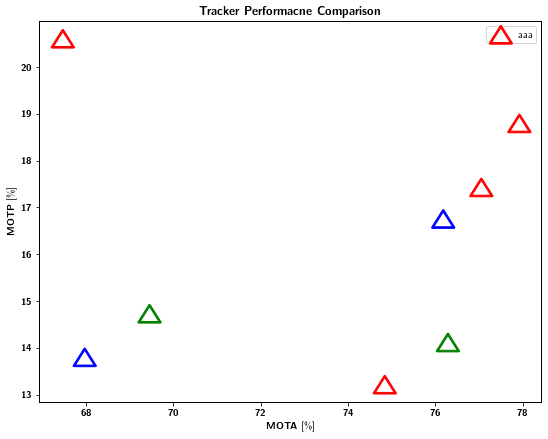

In [19]:
def build_prop_dict(vals, vals_prop_map, prop_name):
    prop_vals = [vals_prop_map[v] for v in vals]
    prop_dict = {prop_name: prop_vals}
    return prop_dict

def build_axis_label(text, units=None):
    label = rf'$\textbf{{{text}}}$'
    if units is not None:
        label += f' [{units}]'
    return label

x_label = 'MOTA'
y_label = 'MOTP'
x_units = y_units = '\%'
size = 25 ** 2

x_label_formatted = build_axis_label(x_label, x_units)
y_label_formatted = build_axis_label(y_label, y_units)

prop_dict = build_prop_dict(models, model_prop_val_map, model_prop)

fig, ax = plt.subplots(figsize=(9, 7), nrows=1, ncols=1)

ax.set_title(r'$\textbf{Tracker Performance Comparison}$')
ax.set_xlabel(x_label_formatted)
ax.set_ylabel(y_label_formatted)

ax.scatter(scores[:, 0], scores[:, 1], s=size, marker=r'$\bigtriangleup$', label="aaa", **prop_dict)
ax.legend(loc='best')

fig.show()